# Exploring attention heads in BERT

In [1]:
import copy
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd

from transformers import BertTokenizer, BertModel

## Functions

In [2]:
def extractAttention(model, tokenizer, sentence_a, sentence_b=False):
    """
    Extract attention, tokens and token_ids for a sentence given model and tokenizer 
    """
    inputs = tokenizer.encode_plus(sentence_a, 
                                   sentence_b=sentence_b, 
                                   return_tensors='pt', 
                                   add_special_tokens=True)
    token_ids = inputs['input_ids']
    token_ids_list = token_ids[0].tolist()
    tokens = tokenizer.convert_ids_to_tokens(token_ids_list)  
    attention = model(token_ids)[-1]
    return attention, tokens, token_ids_list

In [3]:
def measureDissimilarity(one_attention, ref_attention, method="L2"):
    if method == "L2":
        att_diff = (ref_attention - one_attention)**2/np.prod(ref_attention.size())
        att_diff = att_diff.sum()
    elif method == "L1":
        att_diff = abs(ref_attention - one_attention)/np.prod(ref_attention.size())
        att_diff = att_diff.sum()
    return att_diff

In [4]:
def findDissimilarAttentions(attention, accept_threshold=10., dissimilarity_measure="L2"):
    """
    Find dissimilar attention heads (in different layers)
    dissimilarity_measure can be "L1", "L2"
    accept_threshold: if dissimilarity_measure >= accept_threshold, collect the result
    """
    attention_groups = {}
    num_layers = len(attention)
    total_number_heads = 0
    for i in range(num_layers):
        num_heads = len(attention[i][0])
        for j in range(num_heads):
            total_number_heads += 1
            if len(attention_groups) == 0:
                attention_groups[f"{i}_{j}"] = attention[i][0][j]
            else:
                current_attention = attention[i][0][j]
                need2add = True
                for k in iter(attention_groups):
                    saved_attention = attention_groups[k]
                    att_diff = measureDissimilarity(current_attention, 
                                                    saved_attention, 
                                                    method=dissimilarity_measure)
                    if att_diff < accept_threshold:
                        need2add = False
                        break
                    
                if need2add:
                    attention_groups[f"{i}_{j}"] = attention[i][0][j]
                    
    print(f"Total number of attention heads: {total_number_heads}, selected: {len(attention_groups)}")
    return attention_groups

## Read sentences

In [5]:
path2file = "./animacy_goldstandard/Annotation by adjudication.xlsx"
annotation_pd = pd.read_excel(path2file)
annotation_pd.head()

,Unnamed: 0,SentenceId,Sentence,MaskedSentence,TargetExpression,Date,SentenceBookId,CombinedCategories,MasterCategory,CombinedAnimacies,MasterAnimacy,CombinedNegations,MasterNegation,Comments
0,0,000044627_03_355_4,". [SEP] and had almost resolved to go Wffik, w...",". [SEP] and had almost resolved to go Wffik, w...",locomotive,1890,000044627_03_15698,"['GT:machine is agent (mental state)', 'MCA:ma...",machine as a human,"['GT:1', 'MCA:1']",1.0,"['GT:0', 'MCA:0']",0.0,"['GT:nan', 'MCA:nan']"
1,1,000875925_01_269_3,I once made an experiment of this kind on a ch...,I once made an experiment of this kind on a ch...,machine,1887,000875925_01_2411,['GT:machine is inanimate object without agenc...,machine is inanimate object without agency,"['GT:0', 'MCA:0']",0.0,"['GT:0', 'MCA:0']",0.0,"['GT:nan', 'MCA:nan']"
2,2,002179056_12_226_21,"hot-house, the forced labour of the beast iu t...","hot-house, the forced labour of the beast iu t...",machine,1836,002179056_12_5695,"['GT:human as a machine', 'MCA:other']",other,"['GT:0', 'MCA:0']",0.0,"['GT:0', 'MCA:0']",0.0,"['GT:but the machine is a complex system', 'MC..."
3,3,000360617_01_334_6,"The next fifteen or twenty years may, therefor...","The next fifteen or twenty years may, therefor...",machines,1892,000360617_01_5584,['GT:machine is inanimate object without agenc...,machine is inanimate object without agency,"['GT:0', 'MCA:0']",0.0,"['GT:0', 'MCA:1']",1.0,"['GT:nan', 'MCA:nan']"
4,4,000528601_23_32_1,THE LAST OF THE BARONS. [SEP] 28 ray ; for Con...,THE LAST OF THE BARONS. [SEP] 28 ray ; for Con...,machinery,1895,000528601_23_418,"['GT:human as a machine', 'MCA:machine as a co...",human as a machine,"['GT:0', 'MCA:0']",0.0,"['GT:0', 'MCA:0']",0.0,Human as a system


In [6]:
annotation_pd['MasterCategory'].value_counts()

human as a machine                            124
machine is inanimate object without agency     93
machine is agent (purpose/work)                51
machine is instrument                          34
machine is agent (movement)                    24
machine as a human                             18
other                                          17
machine as a system                            15
machine is agent (mental state)                12
machine as an animal                            2
Name: MasterCategory, dtype: int64

## Filter dataframe

In [7]:
sel_category = 'machine as a human'
annotation_filtered = annotation_pd[annotation_pd['MasterCategory'] == sel_category]
print("Length of the selected dataframe (number of rows):", len(annotation_filtered))
annotation_filtered.head(2)

Length of the selected dataframe (number of rows): 18


,Unnamed: 0,SentenceId,Sentence,MaskedSentence,TargetExpression,Date,SentenceBookId,CombinedCategories,MasterCategory,CombinedAnimacies,MasterAnimacy,CombinedNegations,MasterNegation,Comments
0,0,000044627_03_355_4,". [SEP] and had almost resolved to go Wffik, w...",". [SEP] and had almost resolved to go Wffik, w...",locomotive,1890,000044627_03_15698,"['GT:machine is agent (mental state)', 'MCA:ma...",machine as a human,"['GT:1', 'MCA:1']",1.0,"['GT:0', 'MCA:0']",0.0,"['GT:nan', 'MCA:nan']"
7,7,003364095_02_355_1,FRAGMENTS. [SEP] 331 And the hum of the hot bl...,FRAGMENTS. [SEP] 331 And the hum of the hot bl...,engine,1870,003364095_02_5834,"['GT:machine as a human', 'MCA:machine as a hu...",machine as a human,"['GT:1', 'MCA:1']",1.0,"['GT:0', 'MCA:0']",0.0,"['GT:nan', 'MCA:nan']"


There are two sets of sentences, `Sentence` and `MaskedSentence`. 

In [8]:
annotation_filtered["MaskedSentence"]

0      . [SEP] and had almost resolved to go Wffik, w...
7      FRAGMENTS. [SEP] 331 And the hum of the hot bl...
8      Now that West-African war-drum had been made t...
22     263 POOR LOST MOGGY. [SEP] inspected the curio...
34     This was the first locomotive for railroad pur...
37     They stayed to see Ok Hut brought out insensib...
100    That there was a Roman camp on Castlefield, wi...
117    were sometimes thrown "all of a heap " by thes...
178    The light membranes or husks, which are as thi...
200    At the beginning of the late war the French co...
209    "The story is differently told in Virgil," quo...
247    This was almost a genera tion after that regio...
282    247 Jarvis opened the door of a long, well-lig...
326    Some sprightly soul — an apprentice, be sure —...
343    Gendarmes in brass helmets and blue coats stan...
348    Down — down he kept going; but now it was in c...
394    At the end opposite to the rows of spindles wa...
396    An hotel company, assist

In [9]:
sentence_a = annotation_filtered["MaskedSentence"].iloc[10]
sentence_a

'"The story is differently told in Virgil," quoth Ricca bocca, peeping out of the window. [SEP] Nevertheless, the [MASK] looks very large and suspicious; unloose Pom pey. [SEP] "Father," said Violante, colouring, "it is your friend, Lord L\'Estrange; I hear his voice."'

## Change the sentence?

In [10]:
sentence_a = "They were told that the [MASK] stopped working."

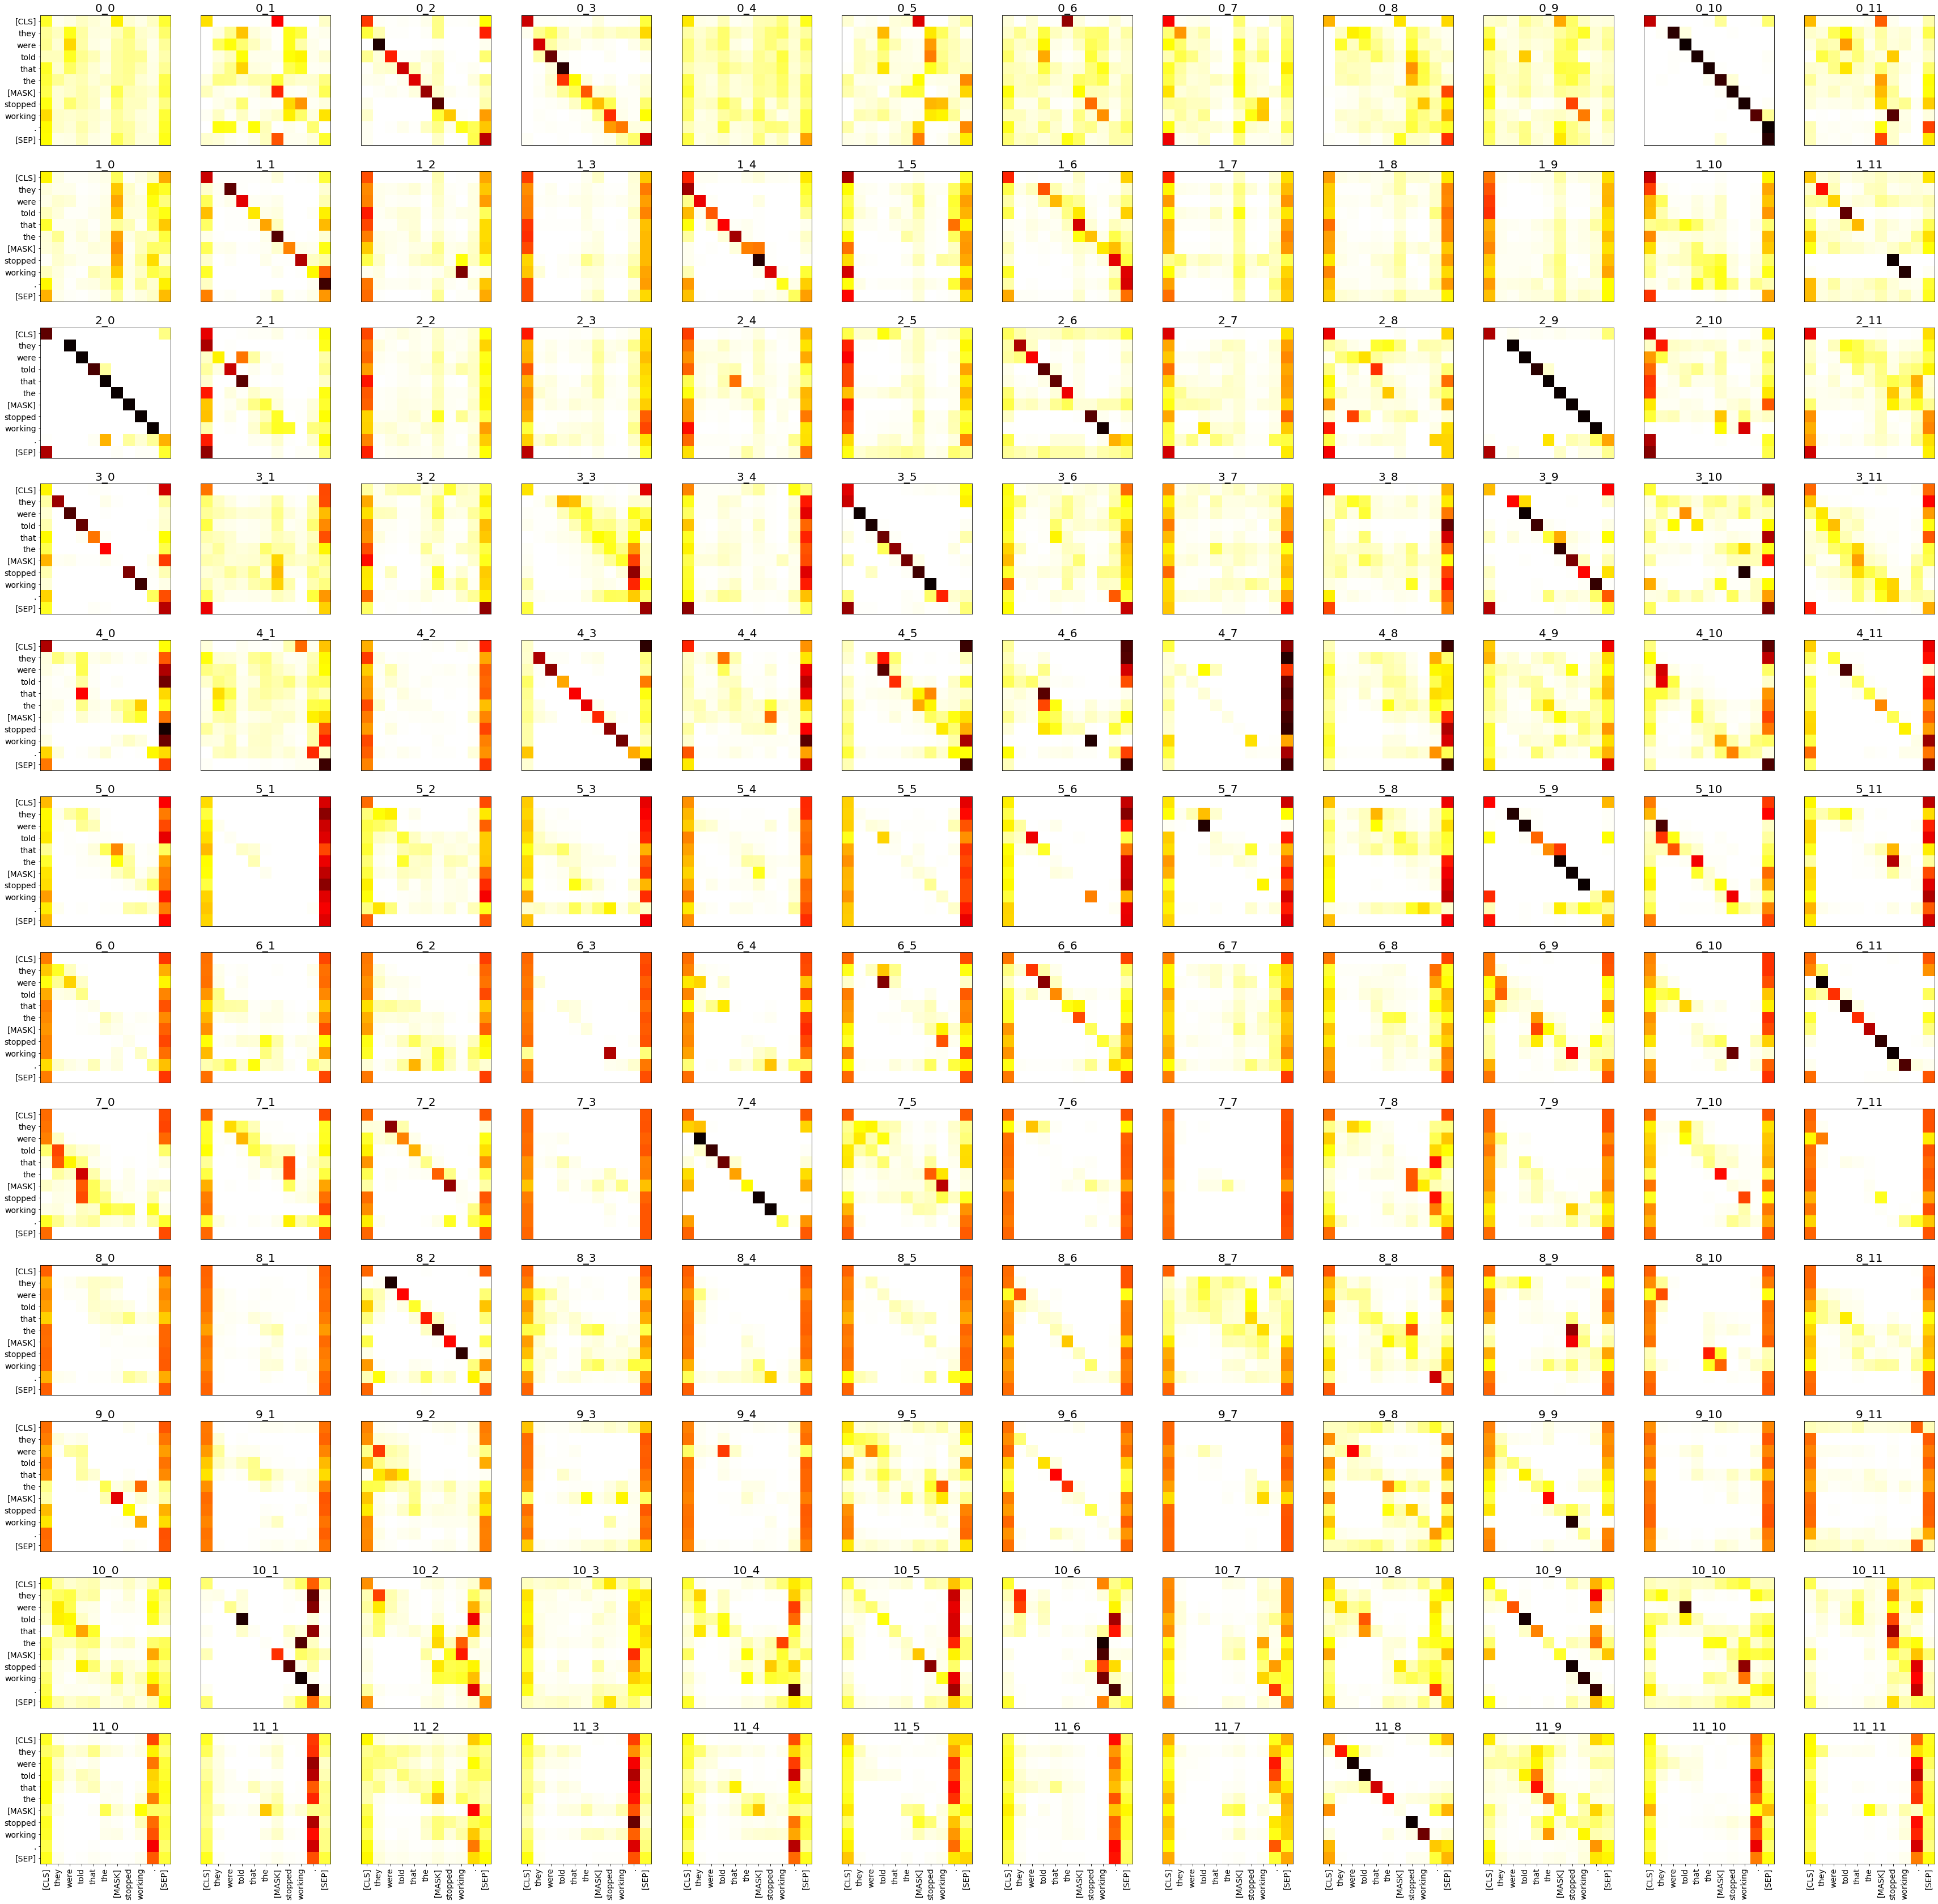

In [11]:
model_type = 'bert'
do_lower_case = True
model_list = ["./bert_models/FT_bert_base_uncased_before_1850_v001/", 
              "./bert_models/FT_bert_base_uncased_after_1850_before_1875_v002/",
              "./bert_models/FT_bert_base_uncased_after_1875_before_1890_v002/",
              "./bert_models/FT_bert_base_uncased_after_1890_before_1900_v002/"
             ]
sel_model_list = model_list[3]
model = BertModel.from_pretrained(sel_model_list, output_attentions=True)
tokenizer = BertTokenizer.from_pretrained(sel_model_list, do_lower_case=do_lower_case)
attention, tokens, token_ids_list = extractAttention(model, tokenizer, sentence_a)

num_layers = len(attention)
num_heads = len(attention[0][0])
plt.figure(figsize=(num_layers*5, num_heads*5), facecolor='w')
for i in range(num_layers):
    num_heads = len(attention[i][0])
    for j in range(num_heads):     
        plt.subplot(num_layers, num_heads, i*num_heads+j+1)
        plt.imshow(attention[i][0][j].detach().numpy(), 
           cmap='hot_r', vmin=0, vmax=1)
        plt.title(f'{i}_{j}', size=20)
        #plt.colorbar()
        if j == 0:
            plt.yticks(range(0, len(tokens)), tokens, size=14)
        else:
            plt.xticks([], [])
            plt.yticks([], [])
        if i == (num_layers - 1):
            plt.xticks(range(0, len(tokens)), tokens, size=14, rotation=90)
        else:
            plt.xticks([], [])
            
        plt.xlim(-0.5, len(tokens)-0.5)
        plt.ylim(len(tokens)-0.5, -0.5)
        #plt.grid()

In [12]:
model_type = 'bert'
accept_threshold = 0.025
dissimilarity_measure = "L2"
do_lower_case = True
model_list = ["./bert_models/FT_bert_base_uncased_before_1850_v001/", 
              "./bert_models/FT_bert_base_uncased_after_1850_before_1875_v002/",
              "./bert_models/FT_bert_base_uncased_after_1875_before_1890_v002/",
              "./bert_models/FT_bert_base_uncased_after_1890_before_1900_v002/"
             ]

all_attention_groups = []
for model_version in model_list:
    model = BertModel.from_pretrained(model_version, output_attentions=True)
    tokenizer = BertTokenizer.from_pretrained(model_version, do_lower_case=do_lower_case)

    attention, tokens, token_ids_list = extractAttention(model, tokenizer, sentence_a)
    attention_groups = findDissimilarAttentions(attention, 
                                                accept_threshold=accept_threshold, 
                                                dissimilarity_measure=dissimilarity_measure)
    all_attention_groups.append(attention_groups)

Total number of attention heads: 144, selected: 16
Total number of attention heads: 144, selected: 13
Total number of attention heads: 144, selected: 13
Total number of attention heads: 144, selected: 18


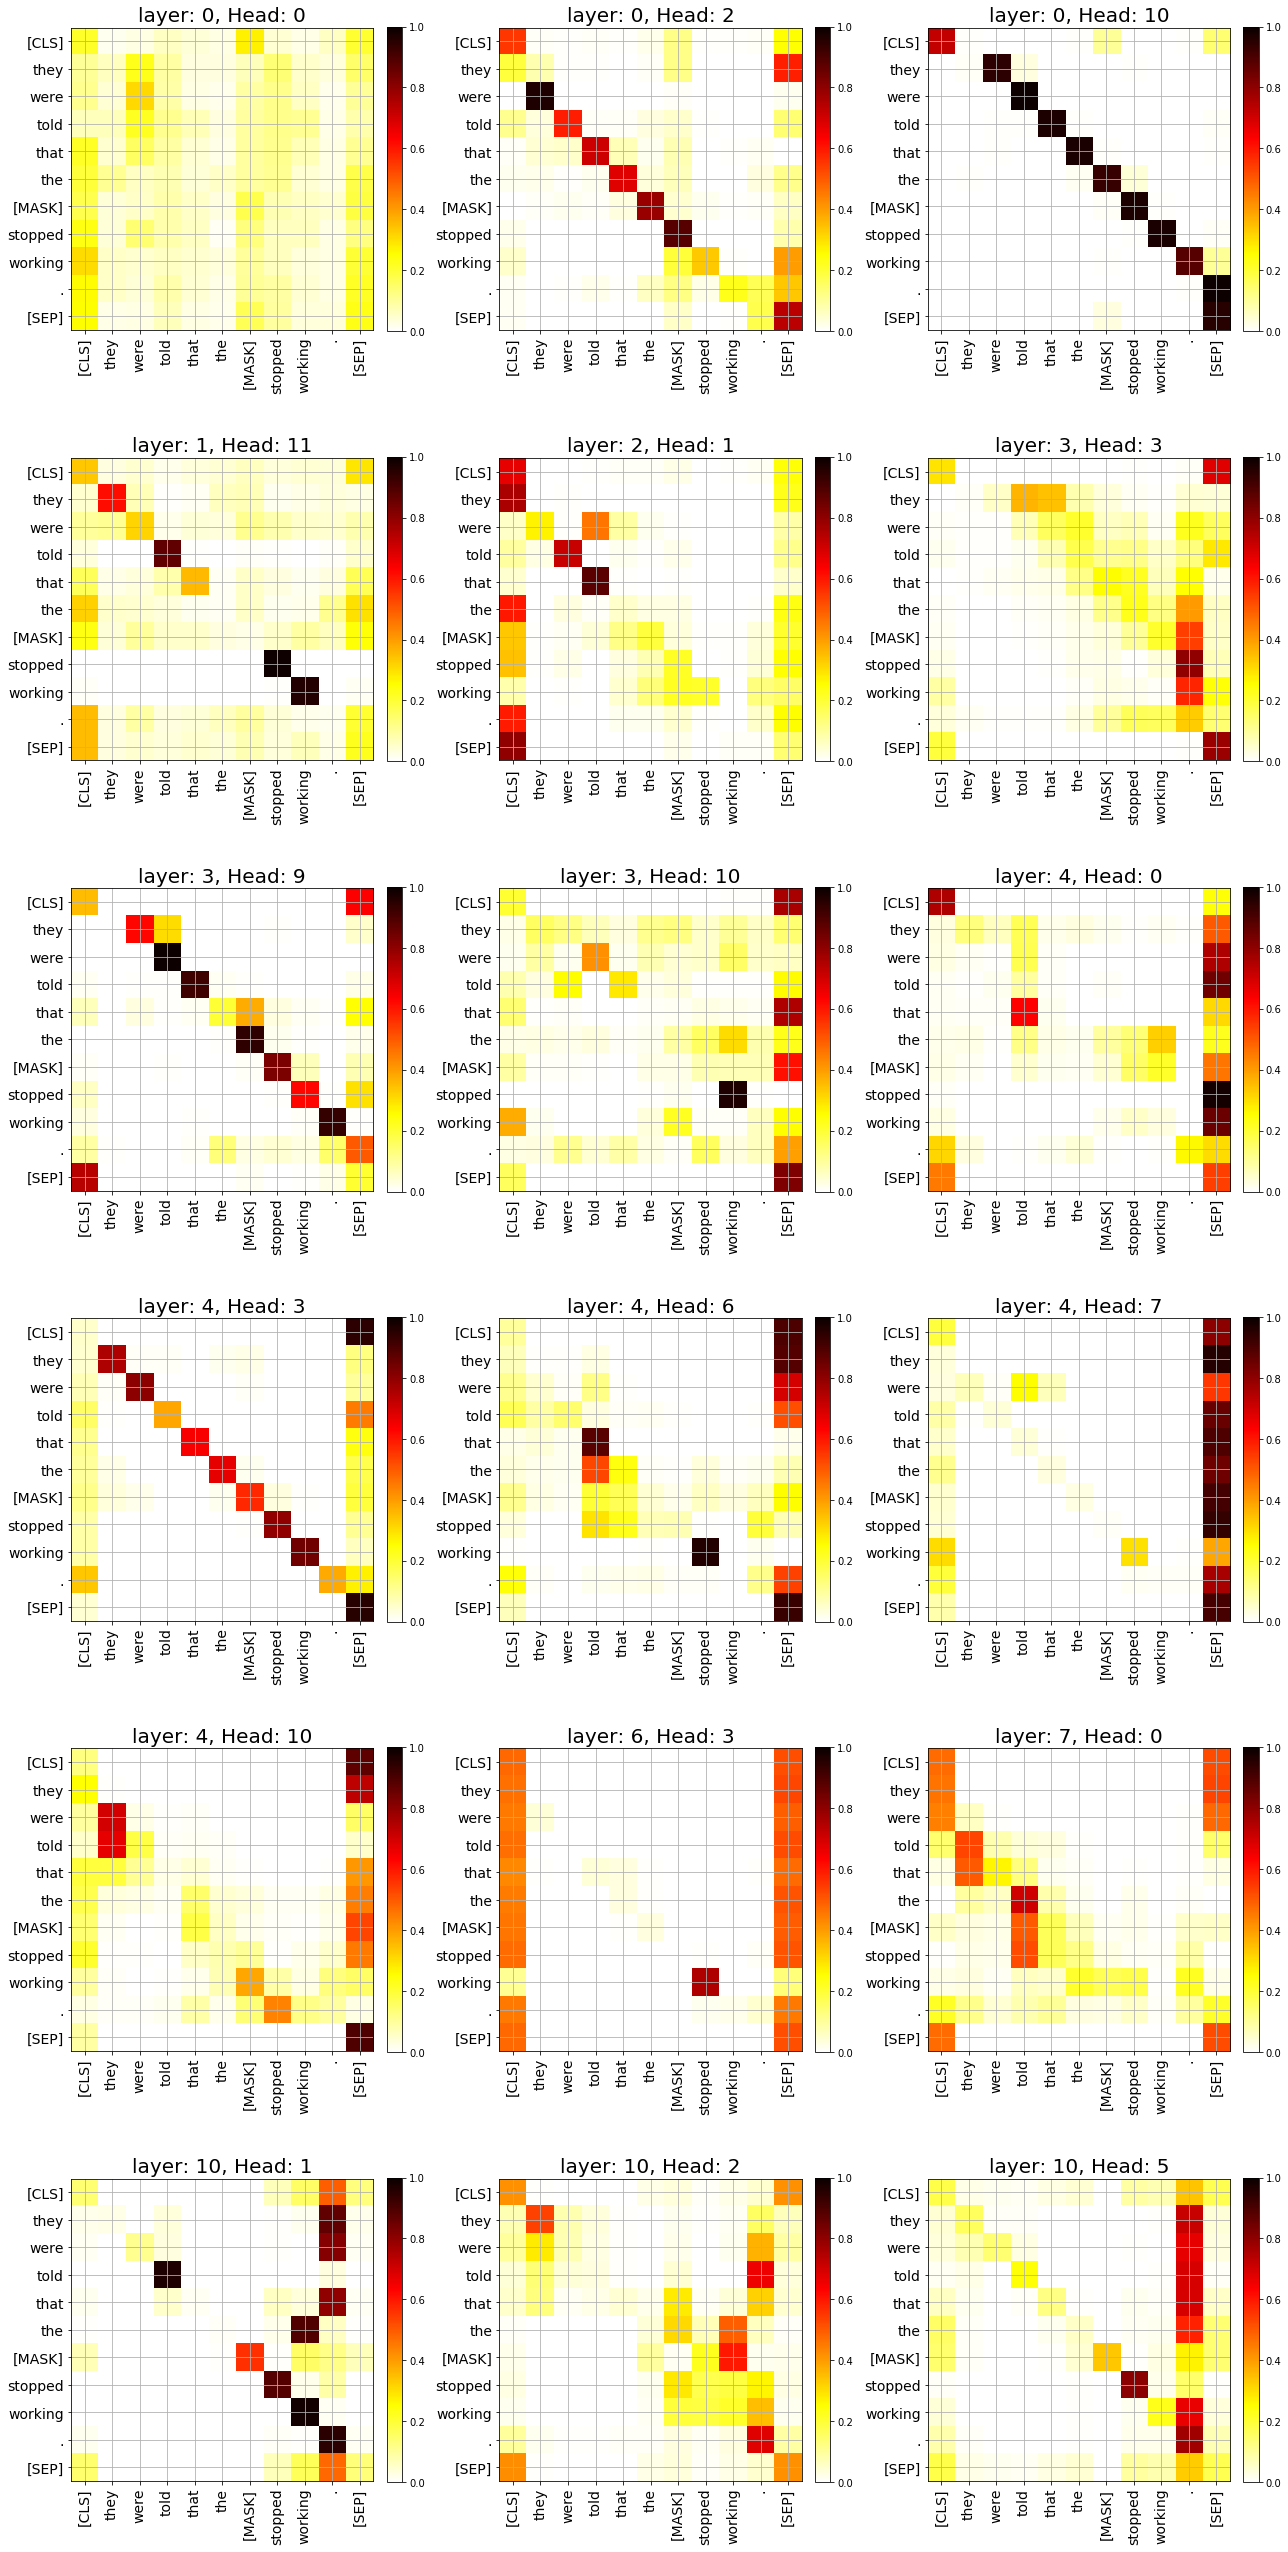

In [13]:
sel_attention_group = all_attention_groups[3]

plt.figure(figsize=(1.0*len(sel_attention_group), 2.0*len(sel_attention_group)), facecolor='w')
for iatt, att2plot in enumerate(sel_attention_group):
    plt.subplot(int(math.ceil(len(sel_attention_group))/3.), 3, iatt+1)
    im = plt.imshow(sel_attention_group[att2plot].detach().numpy(), 
                    cmap='hot_r', vmin=0, vmax=1)
    plt.title(f'layer: {att2plot.split("_")[0]}, Head: {att2plot.split("_")[1]}', 
              size=20)
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.xticks(range(0, len(tokens)), tokens, size=14, rotation=90)
    plt.yticks(range(0, len(tokens)), tokens, size=14)
    plt.xlim(-0.5, len(tokens)-0.5)
    plt.ylim(len(tokens)-0.5, -0.5)
    plt.grid()
plt.tight_layout()

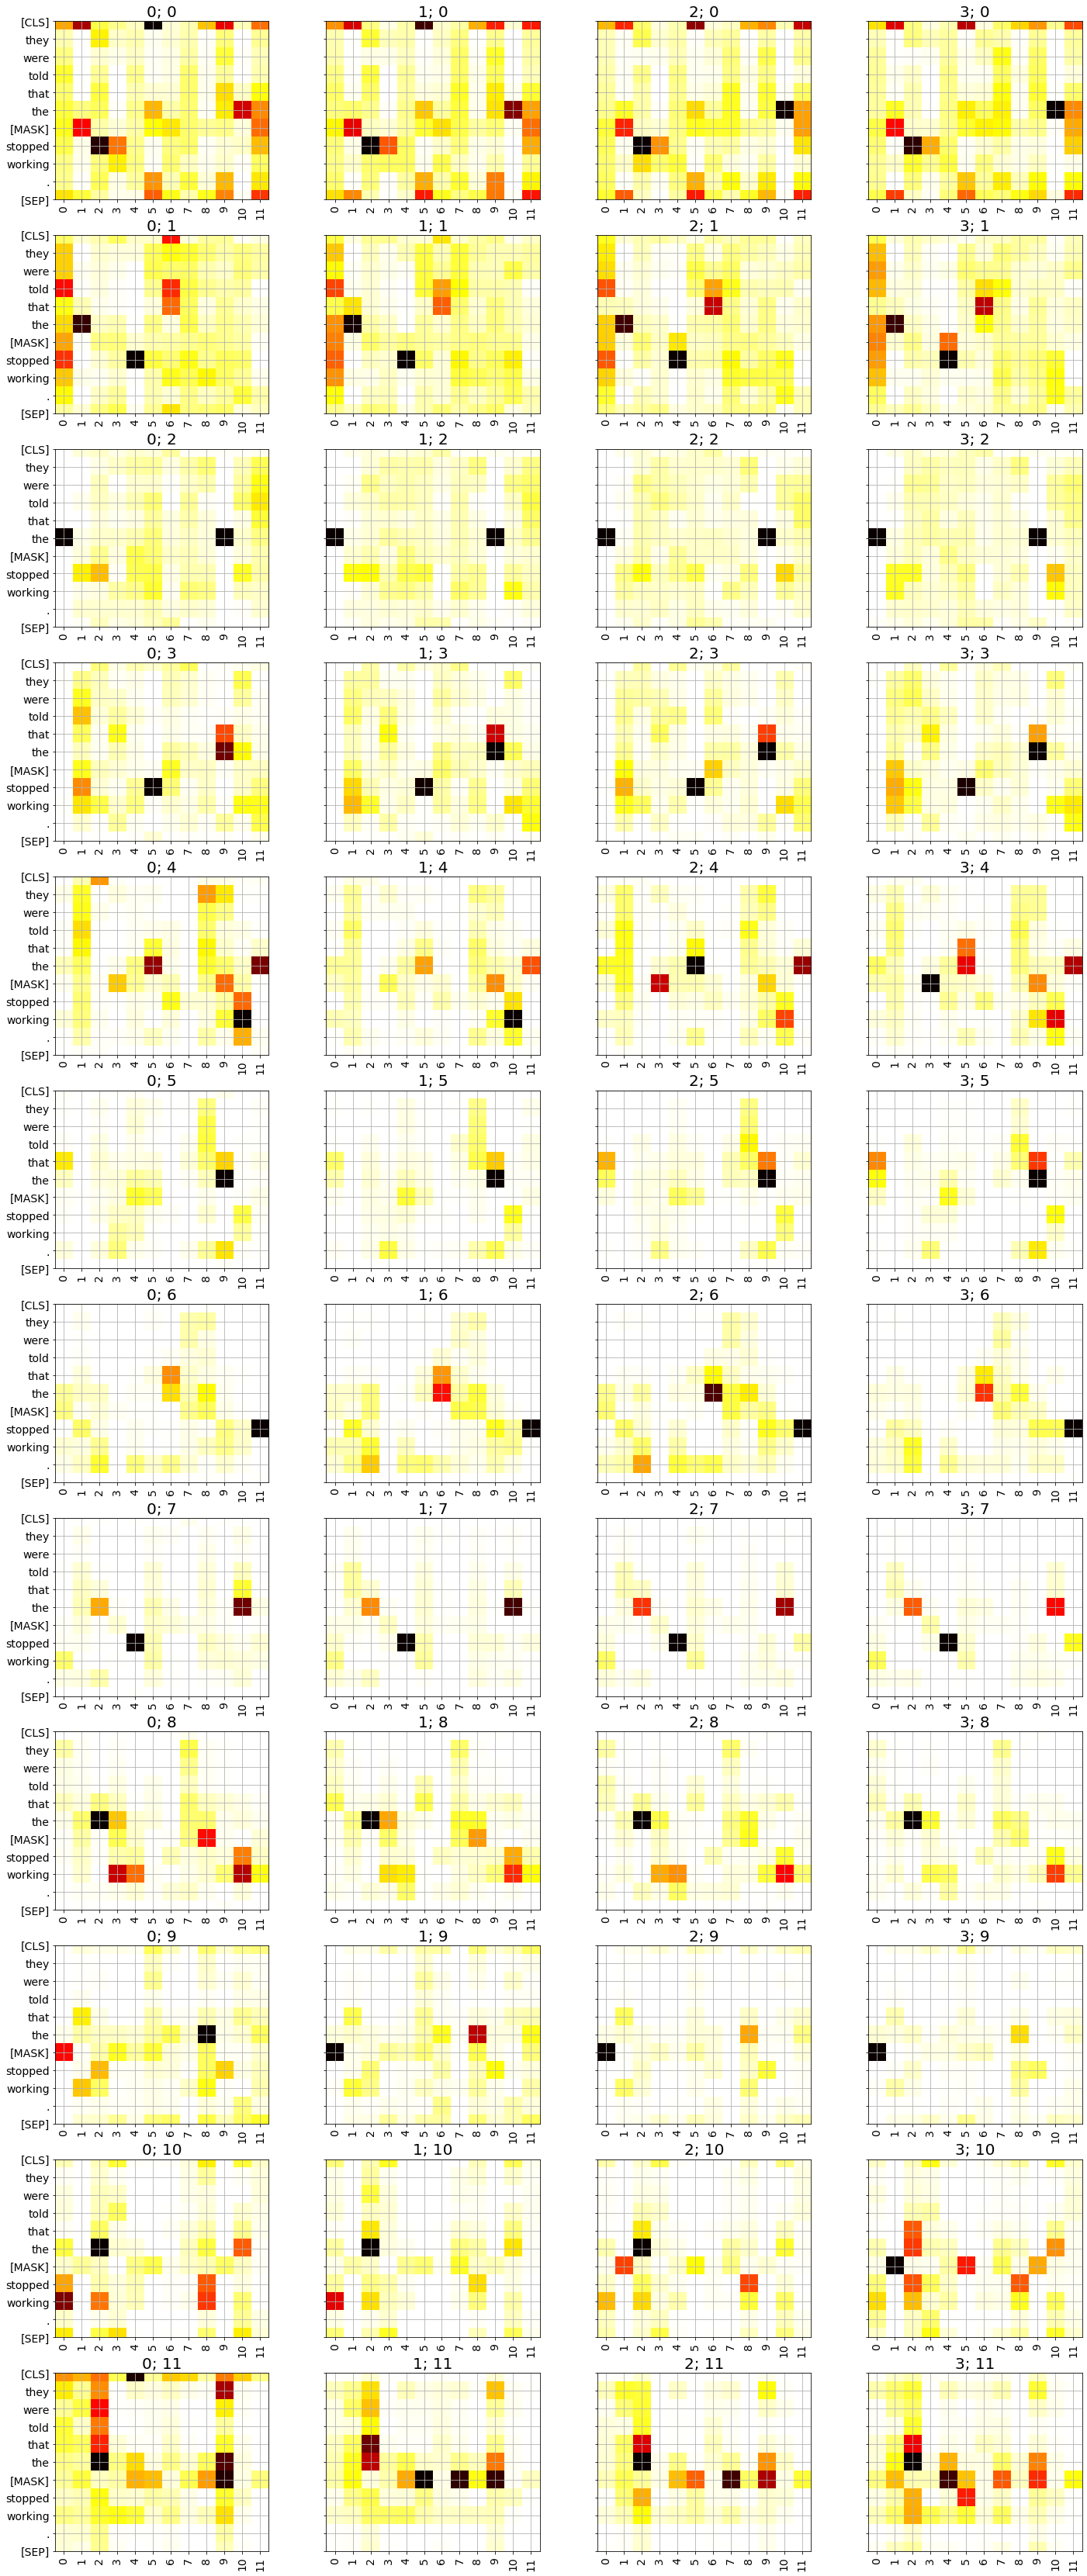

In [14]:
model_type = 'bert'
do_lower_case = True
model_list = ["./bert_models/FT_bert_base_uncased_before_1850_v001/", 
              "./bert_models/FT_bert_base_uncased_after_1850_before_1875_v002/",
              "./bert_models/FT_bert_base_uncased_after_1875_before_1890_v002/",
              "./bert_models/FT_bert_base_uncased_after_1890_before_1900_v002/"
             ]

sel_token = "[MASK]"
num_layers = 12
plt.figure(figsize=(len(model_list)*6, num_layers*5), facecolor='w')
all_attention_groups = []
for imodel, model_version in enumerate(model_list):
    model = BertModel.from_pretrained(model_version, output_attentions=True)
    tokenizer = BertTokenizer.from_pretrained(model_version, do_lower_case=do_lower_case)
    attention, tokens, token_ids_list = extractAttention(model, tokenizer, sentence_a)
    num_layers = len(attention)

    for ilayer in range(num_layers):
        plt.subplot(num_layers, len(model_list), imodel+len(model_list)*ilayer+1)
        plt.imshow(attention[ilayer][0][:, :, tokens.index(sel_token)].detach().numpy().T, cmap='hot_r')
        plt.title(f'{imodel}; {ilayer}', size=20)
        plt.xticks(range(0, 12), size=14, rotation=90)
        if imodel == 0:
            plt.yticks(range(0, len(tokens)), tokens, size=14)
        else:
            plt.yticks(range(0, len(tokens)), [])
        plt.grid()

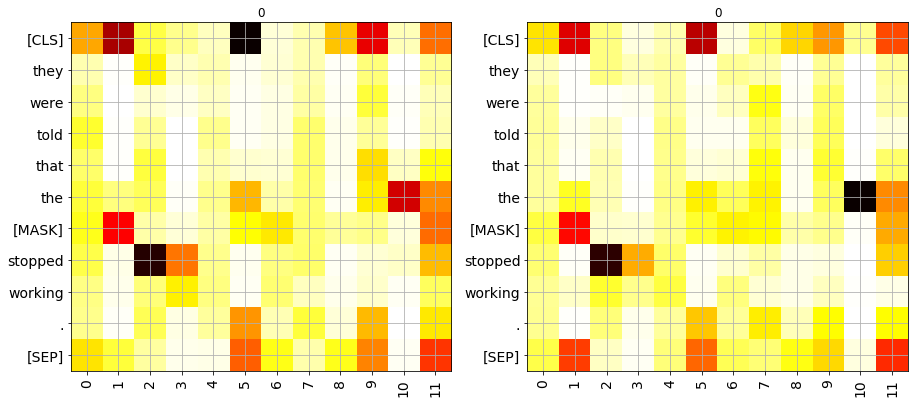

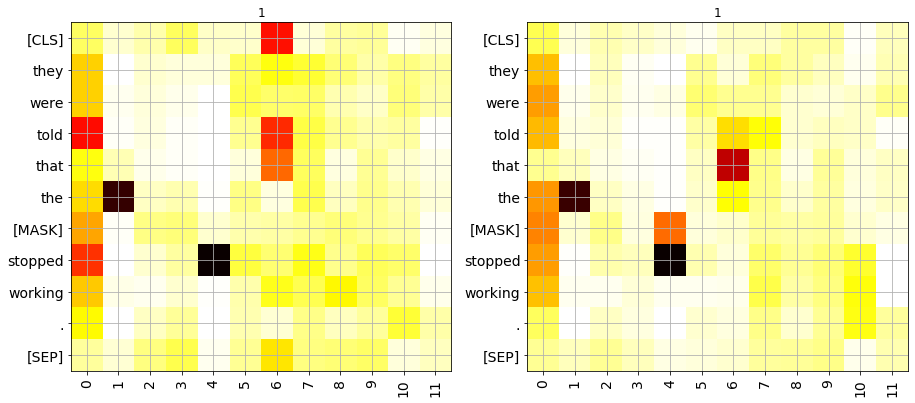

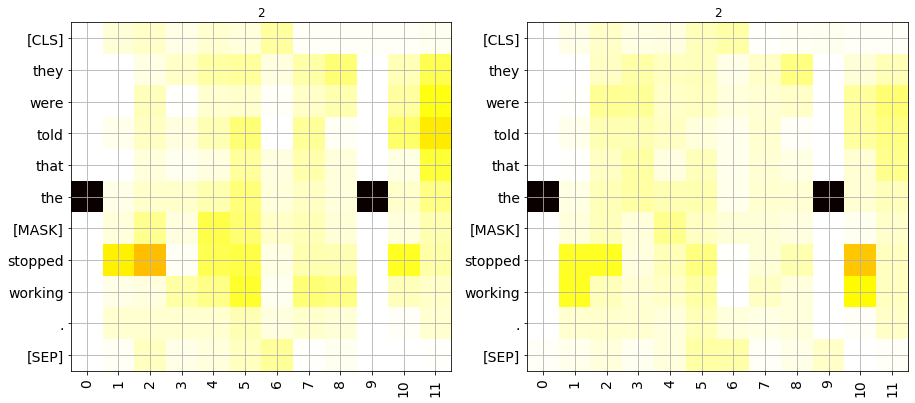

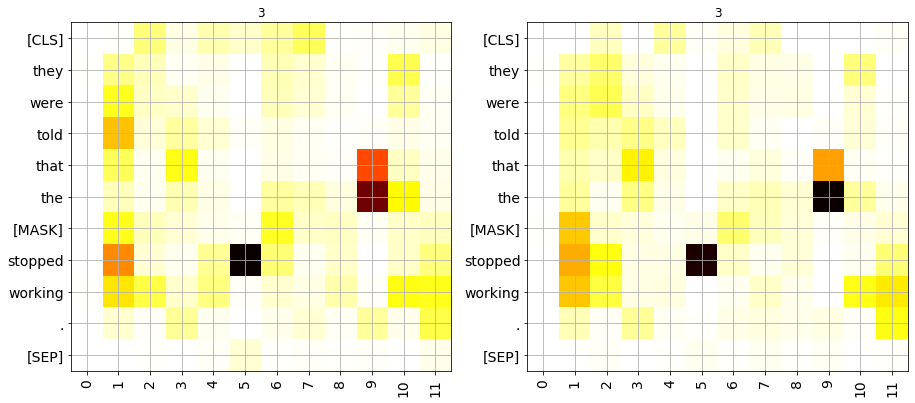

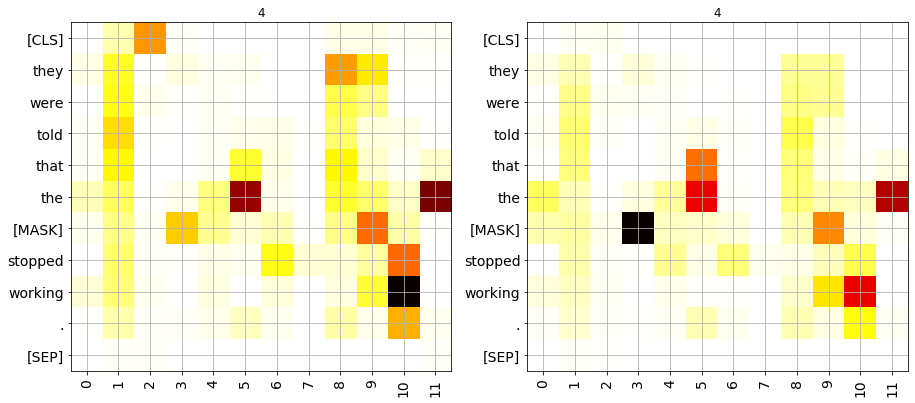

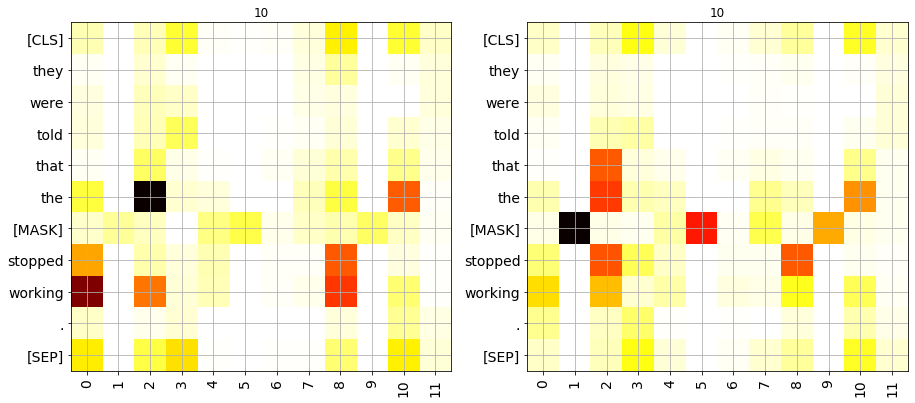

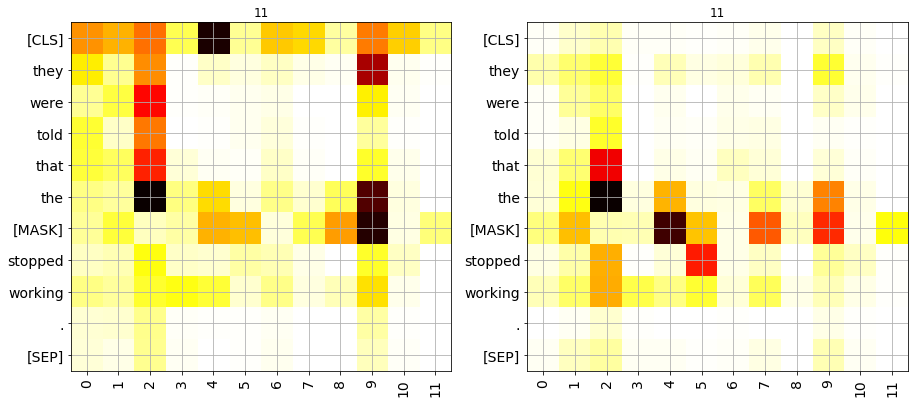

In [15]:
model_type = 'bert'
do_lower_case = True
model_list = ["./bert_models/FT_bert_base_uncased_before_1850_v001/", 
              "./bert_models/FT_bert_base_uncased_after_1850_before_1875_v002/",
              "./bert_models/FT_bert_base_uncased_after_1875_before_1890_v002/",
              "./bert_models/FT_bert_base_uncased_after_1890_before_1900_v002/"
             ]
first_att_indx = 0
second_att_indx = 3
threshold = 0.1

sel_token = "[MASK]"

model = BertModel.from_pretrained(model_list[first_att_indx], output_attentions=True)
tokenizer = BertTokenizer.from_pretrained(model_list[first_att_indx], do_lower_case=do_lower_case)
attention_first, tokens, token_ids_list = extractAttention(model, tokenizer, sentence_a)

model = BertModel.from_pretrained(model_list[second_att_indx], output_attentions=True)
attention_secon, tokens, token_ids_list = extractAttention(model, tokenizer, sentence_a)

num_layers = len(attention)
all_diff_L2 = []
all_diff_threshold = []

for ilayer in range(num_layers):
    one_layer_first = copy.deepcopy(attention_first[ilayer][0][:, :, tokens.index(sel_token)].detach().numpy().T)
    one_layer_secon = copy.deepcopy(attention_secon[ilayer][0][:, :, tokens.index(sel_token)].detach().numpy().T)
    # First method
    layer_diff = abs(one_layer_first - one_layer_secon)**2
    layer_diff = np.sum(layer_diff)/np.prod(one_layer_first.shape)
    all_diff_L2.append(layer_diff)
    # Second method
    one_layer_first[one_layer_first < threshold] = 0.
    one_layer_first[one_layer_first >= threshold] = 1.
    one_layer_secon[one_layer_secon < threshold] = 0.
    one_layer_secon[one_layer_secon >= threshold] = 1.
    diff_first_second = abs(one_layer_first - one_layer_secon)
    diff_first_second = diff_first_second.sum()
    all_diff_threshold.append(diff_first_second)
    
    if diff_first_second > 8:
        plt.figure(figsize=(15, 10))

        plt.subplot(1, 2, 1)
        plt.imshow(attention_first[ilayer][0][:, :, tokens.index(sel_token)].detach().numpy().T, cmap='hot_r')
        plt.yticks(range(0, len(tokens)), tokens, size=14)
        plt.xticks(range(0, num_layers), size=14, rotation=90)
        plt.ylim(len(tokens)-0.5, -0.5)
        plt.xlim(-0.5, 12-0.5)
        plt.title(ilayer)
        plt.grid()
        
        plt.subplot(1, 2, 2)
        plt.imshow(attention_secon[ilayer][0][:, :, tokens.index(sel_token)].detach().numpy().T, cmap='hot_r')
        plt.yticks(range(0, len(tokens)), tokens, size=14)
        plt.xticks(range(0, num_layers), size=14, rotation=90)
        plt.ylim(len(tokens)-0.5, -0.5)
        plt.xlim(-0.5, 12-0.5)
        plt.title(ilayer)
        plt.grid()
    plt.show()

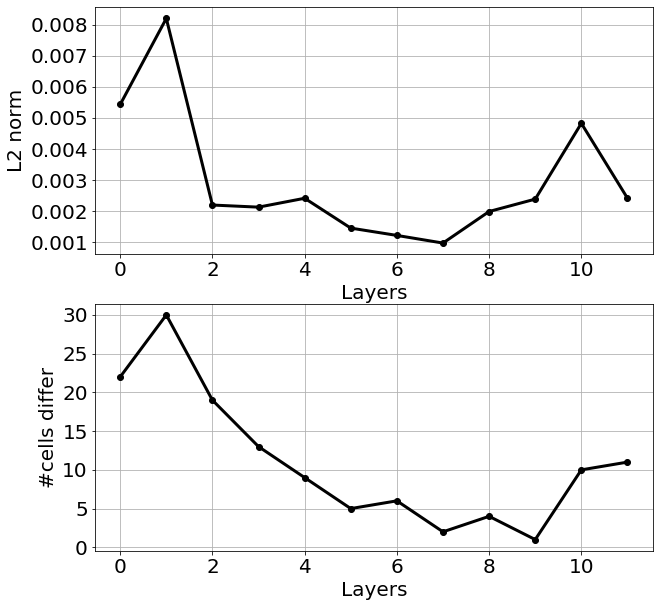

In [16]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(all_diff_L2, color='k', marker='o', lw=3)
plt.xticks(size=20)
plt.yticks(size=20)
plt.ylabel("L2 norm", size=20)
plt.xlabel("Layers", size=20)
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(all_diff_threshold, color='k', marker='o', lw=3)
plt.xticks(size=20)
plt.yticks(size=20)
plt.ylabel("#cells differ", size=20)
plt.xlabel("Layers", size=20)
plt.grid()

# Playground!

In [ ]:
from bertviz.transformers_neuron_view import BertModel as BertModel_bertviz
from bertviz.transformers_neuron_view import BertTokenizer as BertTokenizer_bertviz
from bertviz.neuron_view import show

In [ ]:
%%javascript
require.config({
  paths: {
      d3: '//cdnjs.cloudflare.com/ajax/libs/d3/5.7.0/d3.min',
    jquery: '//ajax.googleapis.com/ajax/libs/jquery/2.0.0/jquery.min',
  }
});

In [ ]:
do_lower_case = True
model = BertModel_bertviz.from_pretrained(model_version)
tokenizer = BertTokenizer_bertviz.from_pretrained(model_version, do_lower_case=do_lower_case)
show(model, model_type, tokenizer, sentence_a)

In [ ]:
for ilabel, attention_groups in enumerate(all_attention_groups):
    plt.plot(attention_groups["2_0"].detach().numpy()[:, tokens.index("[MASK]")], label=f"{ilabel+1}")
plt.legend()

In [ ]:
list_keys = all_attention_groups[0].keys()

In [ ]:
list_keys

In [ ]:
for one_key in list_keys:
    att01 = all_attention_groups[0][one_key].detach().numpy()[tokens.index("[MASK]"), :]
    att02 = all_attention_groups[1][one_key].detach().numpy()[tokens.index("[MASK]"), :]
    att03 = all_attention_groups[2][one_key].detach().numpy()[tokens.index("[MASK]"), :]
    att04 = all_attention_groups[3][one_key].detach().numpy()[tokens.index("[MASK]"), :]
    diff_arr = [
        np.sum(np.abs(att02 - att01))/len(att01),
        np.sum(np.abs(att03 - att01))/len(att01),
        np.sum(np.abs(att04 - att01))/len(att01),
        np.sum(np.abs(att03 - att02))/len(att01),
        np.sum(np.abs(att04 - att02))/len(att01),
        np.sum(np.abs(att04 - att03))/len(att01)
    ]
    max_diff_arr = max(diff_arr)
    if max_diff_arr > 0.005:
        plt.figure()
        plt.title(one_key)
        plt.plot(att01, label="1")
        plt.plot(att02, label="2")
        plt.plot(att03, label="3")
        plt.plot(att04, label="4")
        plt.legend()

In [ ]:
plt.figure(figsize=(20, 20))
att2plot = "8_1"
plt.imshow(all_attention_groups[0][att2plot].detach().numpy(), 
           cmap='hot_r', 
           vmin=0, 
           vmax=1)
plt.title(f'layer: {att2plot.split("_")[0]}, Head: {att2plot.split("_")[1]}', 
          size=20)
plt.colorbar()
plt.xticks(range(0, len(tokens)), tokens, size=14, rotation=90)
plt.yticks(range(0, len(tokens)), tokens, size=14)
plt.xlim(-0.5, len(tokens)-0.5)
plt.ylim(len(tokens)-0.5, -0.5)
plt.grid()

plt.figure(figsize=(20, 20))
plt.imshow(all_attention_groups[3][att2plot].detach().numpy(), 
           cmap='hot_r', 
           vmin=0, 
           vmax=1)
plt.title(f'layer: {att2plot.split("_")[0]}, Head: {att2plot.split("_")[1]}', 
          size=20)
plt.colorbar()
plt.xticks(range(0, len(tokens)), tokens, size=14, rotation=90)
plt.yticks(range(0, len(tokens)), tokens, size=14)
plt.xlim(-0.5, len(tokens)-0.5)
plt.ylim(len(tokens)-0.5, -0.5)
plt.grid()

plt.show()

In [ ]:
plt.plot(attention_groups[att2plot].detach().numpy()[:, 26])

In [ ]:
for att2plot in attention_groups:
    plt.figure(figsize=(20, 20))
    plt.imshow(attention_groups[att2plot].detach().numpy(), 
               cmap='hot_r', 
               vmin=0, 
               vmax=1)
    plt.title(f'layer: {att2plot.split("_")[0]}, Head: {att2plot.split("_")[1]}', 
              size=20)
    plt.colorbar()
    plt.xticks(range(0, len(tokens)), tokens, size=14, rotation=90)
    plt.yticks(range(0, len(tokens)), tokens, size=14)
    plt.xlim(-0.5, len(tokens)-0.5)
    plt.ylim(len(tokens)-0.5, -0.5)
    plt.grid()
    plt.show()

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(attention[11][0][:].sum(axis=0).detach().numpy(), cmap='hot_r', vmin=0, vmax=1)
plt.colorbar()
plt.xticks(range(0, 15))
plt.yticks(range(0, 15))
plt.xlim(-0.5, 14.5)
plt.ylim(14.5, -0.5)
plt.grid()
plt.show()